In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)


# RF > Catboost

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, 

✅ Best Params: {'catboost__border_count': 64, 'catboost__depth': 5, 'catboost__iterations': 200, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


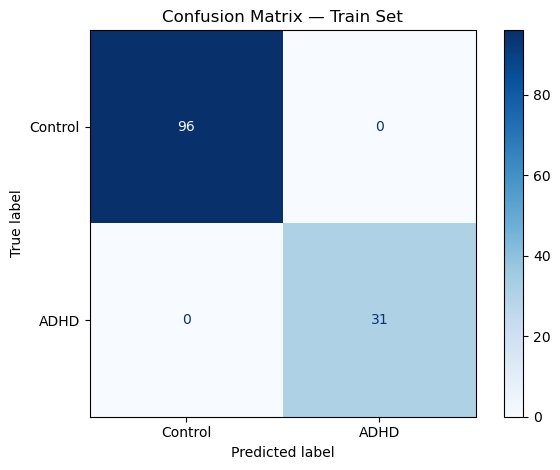

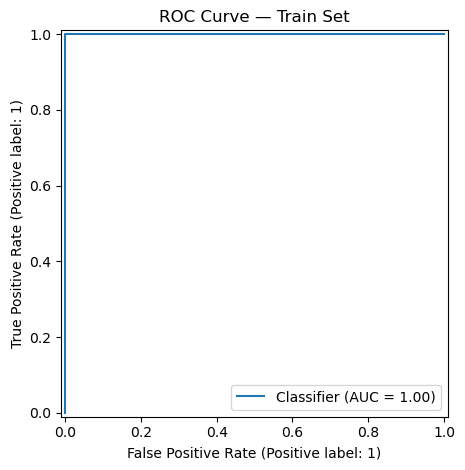

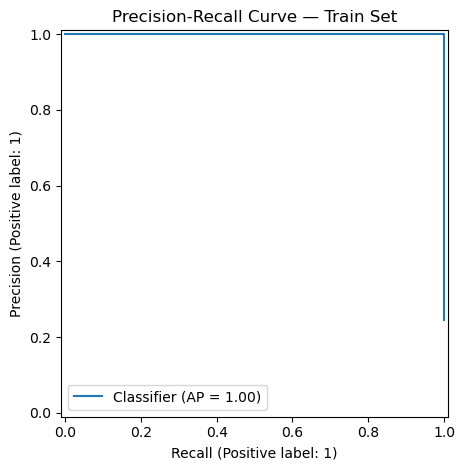

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklea


📊 Cross-Validated Scores:
fit_time: 1.1823
score_time: 0.0444
test_accuracy: 0.7617
train_accuracy: 1.0000
test_precision_macro: 0.5461
train_precision_macro: 1.0000
test_recall_macro: 0.5500
train_recall_macro: 1.0000
test_f1_macro: 0.5201
train_f1_macro: 1.0000
test_roc_auc: 0.6701
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.75      1.00      0.86        24
        ADHD       0.00      0.00      0.00         8

    accuracy                           0.75        32
   macro avg       0.38      0.50      0.43        32
weighted avg       0.56      0.75      0.64        32

ROC AUC (Test): 0.8229166666666667


e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


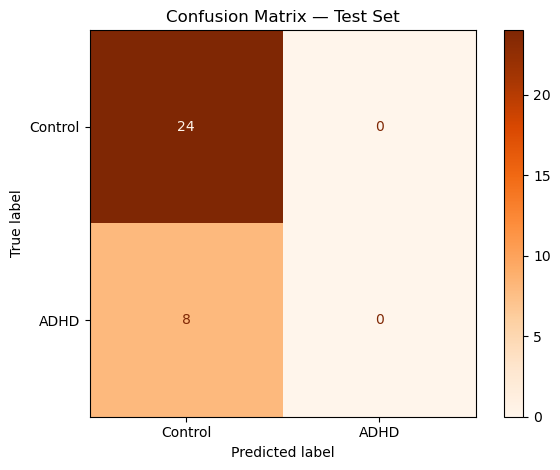

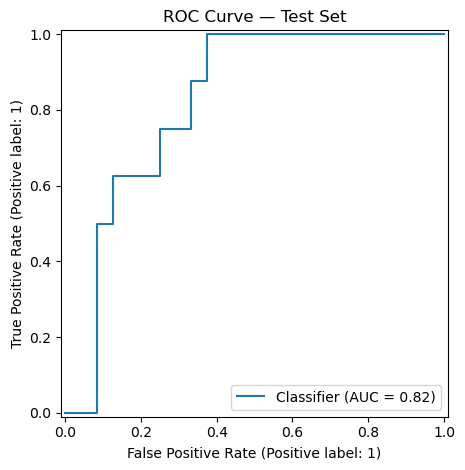

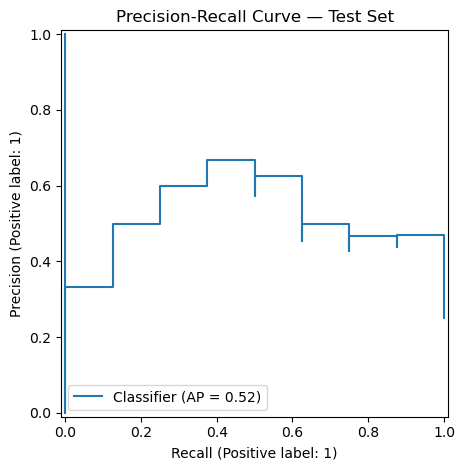

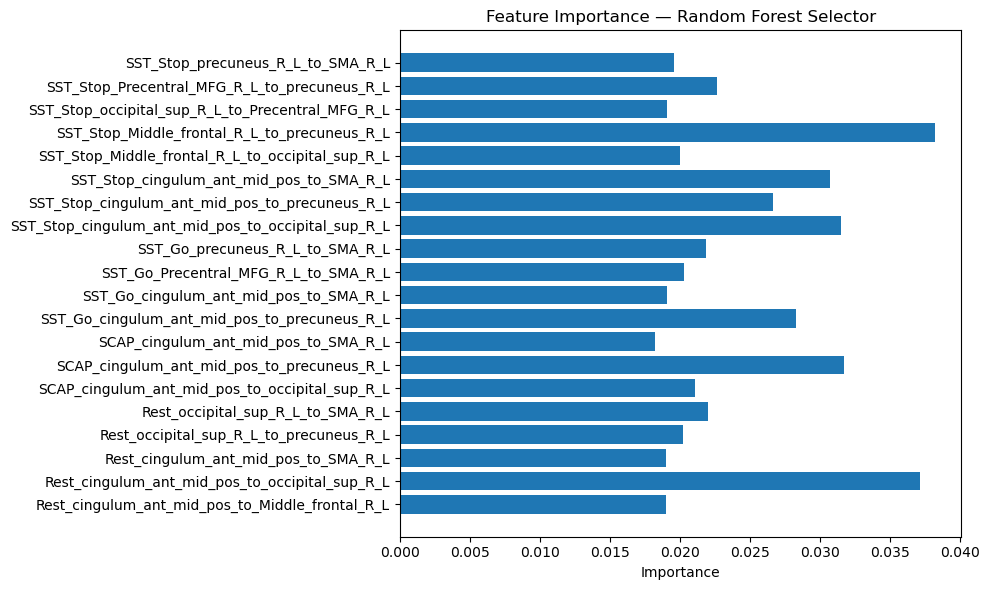

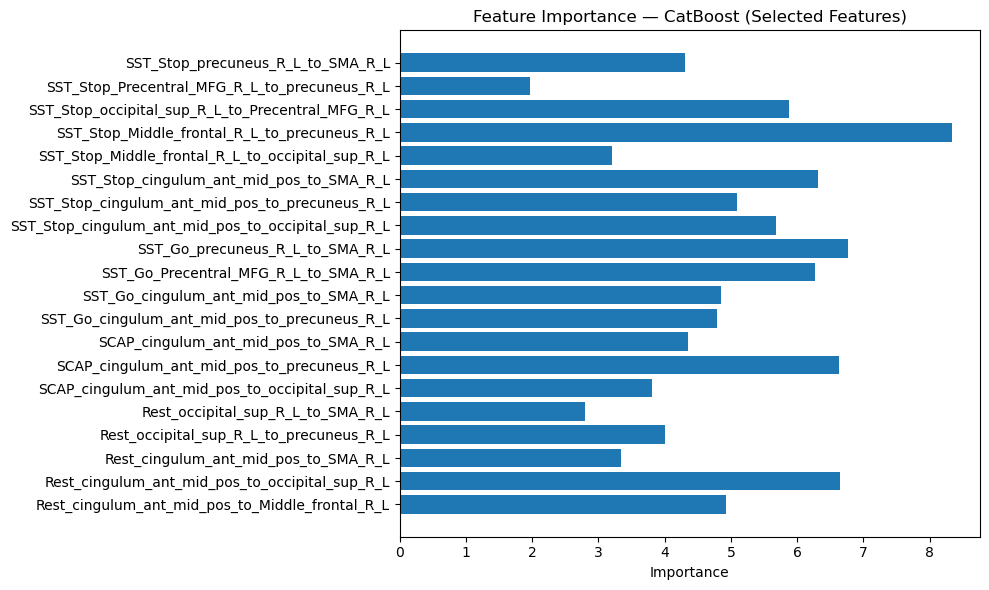

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from catboost import CatBoostClassifier, Pool

# === Stratified K-Fold ===
# === Outer CV for Generalization Performance Estimation ===
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector = SelectFromModel(estimator=rf, threshold=-np.inf, max_features=20)

# === CatBoost Classifier ===
catboost_model = CatBoostClassifier(
    eval_metric='Logloss',  # You might want to fix this
    random_state=42,
    verbose=0
)

# === Pipeline: Raw -> RF selector -> CatBoost ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('catboost', catboost_model)
])

# === Param Grid for CatBoost ===
param_grid = {
    'catboost__iterations': [100, 200, 500],
    'catboost__depth': [4, 5, 6],
    'catboost__learning_rate': [0.01, 0.05, 0.1],
    'catboost__l2_leaf_reg': [1, 3, 5, 7],
    'catboost__border_count': [32, 64, 128]
}

# === Grid SearchCV ===
grid_p1 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=inner_cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p1.fit(X_train, y_train)
print("✅ Best Params:", grid_p1.best_params_)

# === Train Predictions ===
y_train_pred = grid_p1.predict(X_train)
y_train_proba = grid_p1.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p1.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=outer_cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p1.predict(X_test)
y_test_proba = grid_p1.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()

# === 🔍 Feature Importance: Random Forest Selector ===
# === Access the fitted pipeline components ===
best_pipe = grid_p1.best_estimator_
rf_selector = best_pipe.named_steps['feature_select']
rf_model = rf_selector.estimator_
catboost_model = best_pipe.named_steps['catboost']

# === Get selected feature indices ===
selected_indices = rf_selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]

# === Plot Feature Importance: Random Forest ===
rf_importances = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_indices)), rf_importances[selected_indices])
plt.yticks(range(len(selected_indices)), selected_feature_names)
plt.xlabel("Importance")
plt.title("Feature Importance — Random Forest Selector")
plt.tight_layout()
plt.show()

# === Plot Feature Importance: CatBoost (on selected features only) ===
X_selected = X_train.iloc[:, selected_indices]
catboost_model.fit(X_selected, y_train, verbose=0)

catboost_importances = catboost_model.get_feature_importance()

plt.figure(figsize=(10, 6))
plt.barh(range(len(catboost_importances)), catboost_importances)
plt.yticks(range(len(catboost_importances)), selected_feature_names)
plt.xlabel("Importance")
plt.title("Feature Importance — CatBoost (Selected Features)")
plt.tight_layout()
plt.show()



[learning_curve] Training set sizes: [ 14  28  42  57  71  85 100 114 128 143]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.6s finished
e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^

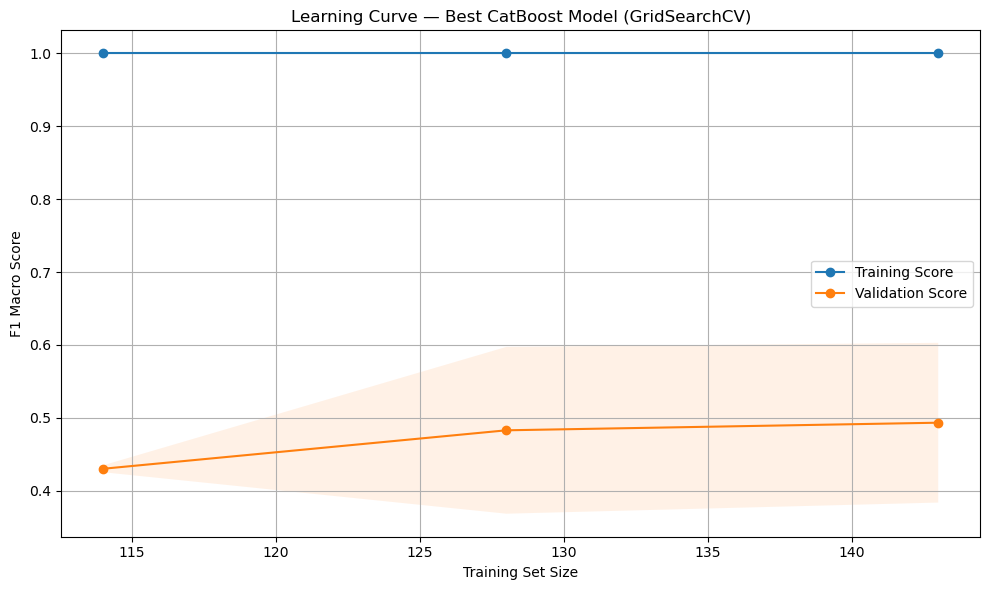

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# === Learning Curve with Best Estimator ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_p1.best_estimator_,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=outer_cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# === Compute Mean and Standard Deviation ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve — Best CatBoost Model (GridSearchCV)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


# CatBoost without feature selection

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


e:\anaconda\envs\basic\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


✅ Best Params: {'catboost__border_count': 128, 'catboost__depth': 4, 'catboost__iterations': 100, 'catboost__l2_leaf_reg': 3, 'catboost__learning_rate': 0.1}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

ROC AUC (Train): 1.0


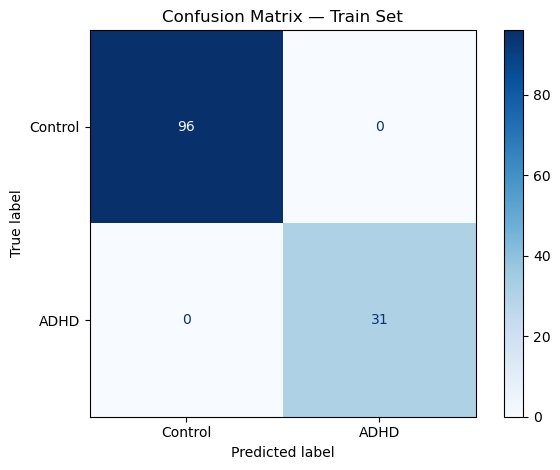

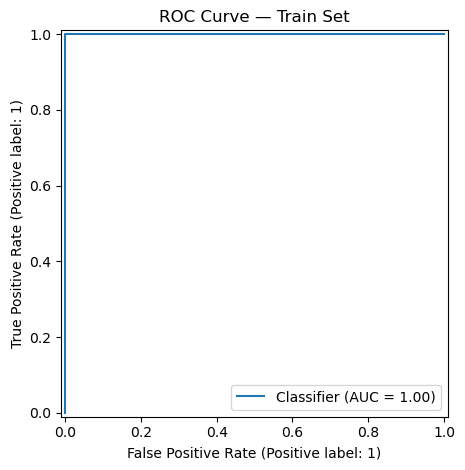

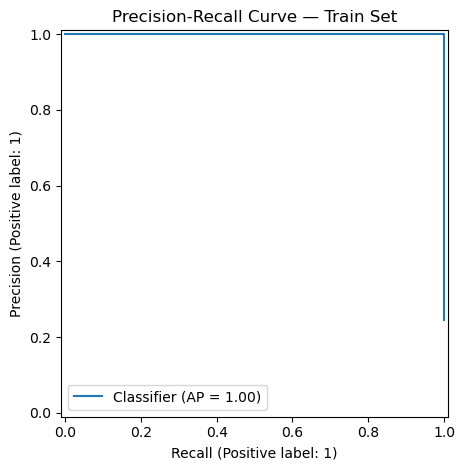

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklea


📊 Cross-Validated Scores:
fit_time: 0.7562
score_time: 0.0270
test_accuracy: 0.7550
train_accuracy: 1.0000
test_precision_macro: 0.5075
train_precision_macro: 1.0000
test_recall_macro: 0.5250
train_recall_macro: 1.0000
test_f1_macro: 0.4851
train_f1_macro: 1.0000
test_roc_auc: 0.6764
train_roc_auc: 1.0000

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.77      0.96      0.85        24
        ADHD       0.50      0.12      0.20         8

    accuracy                           0.75        32
   macro avg       0.63      0.54      0.53        32
weighted avg       0.70      0.75      0.69        32

ROC AUC (Test): 0.8385416666666667


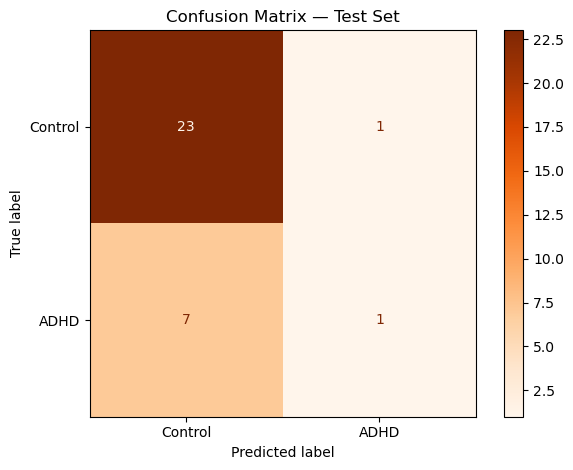

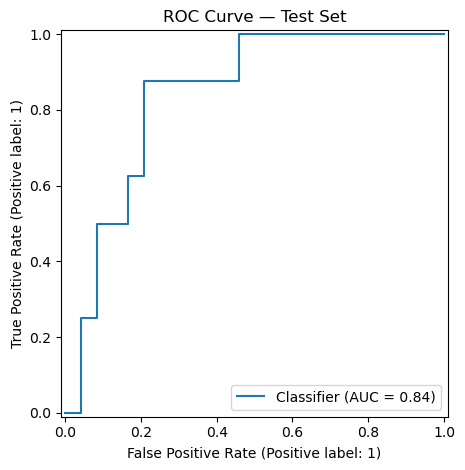

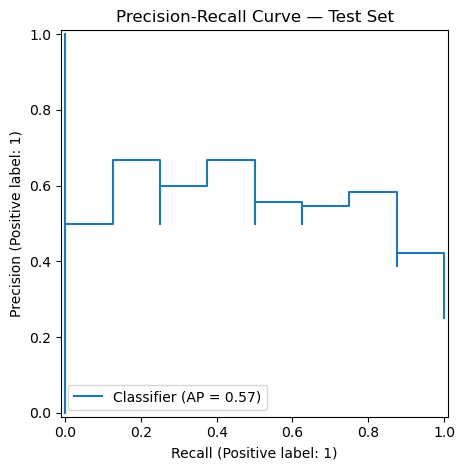

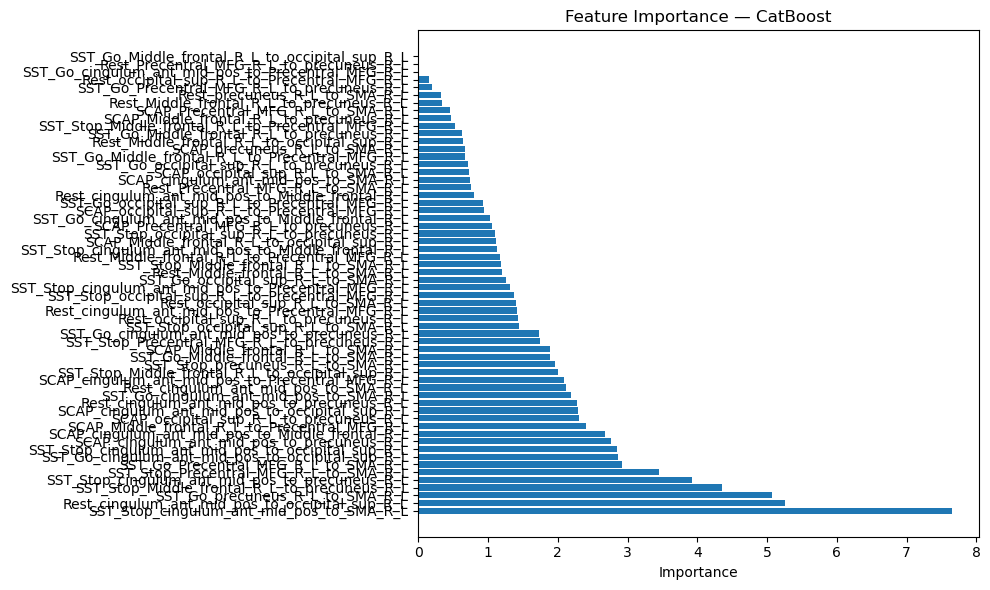

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
from catboost import CatBoostClassifier

# === Stratified K-Fold ===
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === CatBoost Classifier ===
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=5,
    eval_metric='Logloss',
    random_state=42,
    verbose=0
)

# === Pipeline (CatBoost Only) ===
pipeline = Pipeline([
    ('catboost', catboost_model)
])

# === Parameter Grid for GridSearchCV ===
param_grid = {
    'catboost__iterations': [100, 200, 500],
    'catboost__depth': [4, 5, 6],
    'catboost__learning_rate': [0.01, 0.05, 0.1],
    'catboost__l2_leaf_reg': [1, 3, 5, 7],
    'catboost__border_count': [32, 64, 128]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=inner_cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions and Evaluation ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=outer_cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Test Predictions and Evaluation ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()

# === 🔍 Feature Importance from CatBoost ===
best_model = grid_p.best_estimator_.named_steps['catboost']
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importances)[::-1]
plt.barh(range(len(feature_importances)), np.array(feature_importances)[sorted_idx])
plt.yticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance — CatBoost")
plt.tight_layout()
plt.show()


[learning_curve] Training set sizes: [ 14  28  42  57  71  85 100 114 128 143]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.2s finished
e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^

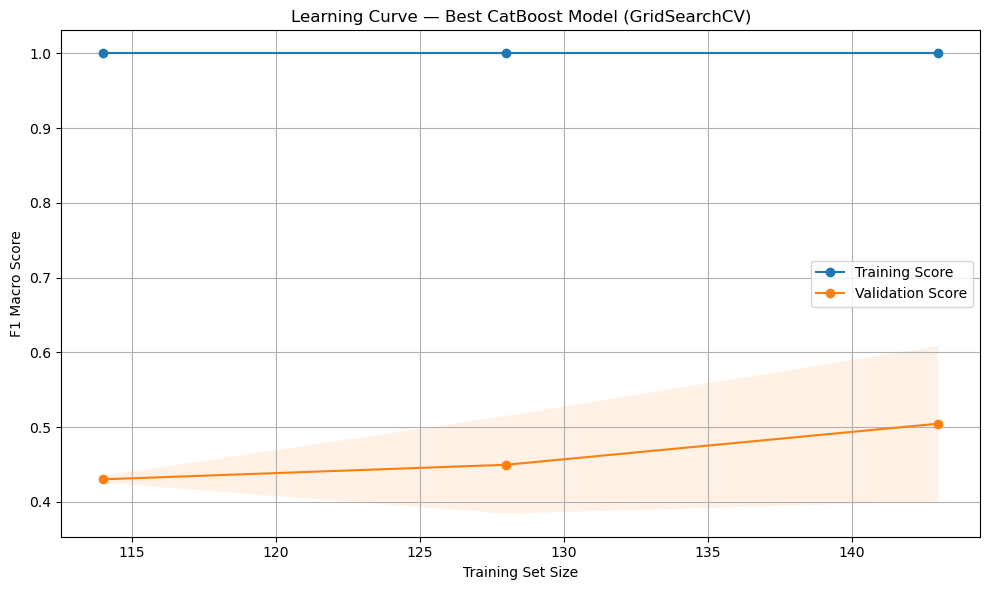

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# === Learning Curve with Best Estimator ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_p.best_estimator_,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=outer_cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# === Compute Mean and Standard Deviation ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === Plot Learning Curve ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve — Best CatBoost Model (GridSearchCV)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()
